# Fraud Detection — Modeling & Hyperparameter Tuning

This notebook covers the full modeling phase, building on the processed features and insights from the processing notebook.

# 1. Setup

## 1.1 Dependencies

In [1]:
# Standard
import os
import json
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
sns.set_theme(style="whitegrid")

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    average_precision_score,
    precision_score, recall_score, f1_score,
    precision_recall_curve,
    classification_report,
    ConfusionMatrixDisplay, confusion_matrix
)

# XGBoost
from xgboost import XGBClassifier

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from utils.processing import sample_stratified_subset, get_dvc_hash

print("All imports OK")

All imports OK


## 1.1 Reproducibility & Paths

In [2]:
RANDOM_SEED  = 42
np.random.seed(RANDOM_SEED)

DATA_PATH    = "../data/processed/fraud_processed.csv"
MLFLOW_URI   = "./mlruns"
EXPERIMENT   = "fraud_modeling"
SUBSET_SIZE  = 1_000_000   # 1M-row training subset (learning curve plateau confirmed)

## 1.2 MLflow Configuration

In [3]:
mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment(EXPERIMENT)

print(f"MLflow tracking URI : {mlflow.get_tracking_uri()}")
print(f"Experiment          : {EXPERIMENT}")

2026/02/21 23:21:31 INFO mlflow.tracking.fluent: Experiment with name 'fraud_modeling' does not exist. Creating a new experiment.


MLflow tracking URI : ./mlruns
Experiment          : fraud_modeling


# 2. Data Loading

**Action Taken**: The processed dataset is used for modeling.

All tuning decisions are made on the training split only.

In [4]:
df = pd.read_csv(DATA_PATH)
print(f"Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Fraud rate: {df['isFraud'].mean()*100:.4f}%")
df.head(3)

Loaded: 6,362,620 rows × 11 columns
Fraud rate: 0.1291%


,type,logAmount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest,destTypeC,isOrigDrained,isFraud
0,PAYMENT,9.194276,170136.0,160296.36,0.0,0.0,0.0,9839.64,0,0,0
1,PAYMENT,7.531166,21249.0,19384.72,0.0,0.0,0.0,1864.28,0,0,0
2,TRANSFER,5.204007,181.0,0.00,0.0,0.0,0.0,181.00,1,1,1


In [5]:
TARGET = 'isFraud'

CAT_FEATURES = ['type']
NUM_FEATURES = [
    'logAmount',
    'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest',
    'errorBalanceOrig', 'errorBalanceDest',
]
BIN_FEATURES = ['destTypeC', 'isOrigDrained']
ALL_FEATURES = CAT_FEATURES + NUM_FEATURES + BIN_FEATURES

X = df[ALL_FEATURES].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=RANDOM_SEED,
    stratify=y
)

print(f"Train : {X_train.shape[0]:>9,} rows  |  fraud: {y_train.sum():,} ({y_train.mean()*100:.3f}%)")
print(f"Test  : {X_test.shape[0]:>9,} rows  |  fraud: {y_test.sum():,} ({y_test.mean()*100:.3f}%)")

Train : 4,453,834 rows  |  fraud: 5,749 (0.129%)
Test  : 1,908,786 rows  |  fraud: 2,464 (0.129%)


## 2.1 Preprocessing Pipeline

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUM_FEATURES),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CAT_FEATURES),
    ],
    remainder='passthrough'
)

## 2.2 Stratified 1M-Row Subset

**Rationale**: The learning curve analysis in the processing notebook showed that
Average Precision plateaus around 1,000,000 training rows. Training on the full
dataset (~4M+ rows) would yield negligible gains at significant computational cost.
All tuning and final model fitting are therefore performed on a stratified 1M-row subset.

In [7]:
def sample_stratified_subset(X, y, n, random_seed=42):
    """Return a stratified subsample of size n, preserving class ratio."""
    if n >= len(X):
        return X, y
    X_sub, _, y_sub, _ = train_test_split(
        X, y,
        train_size=n,
        stratify=y,
        random_state=random_seed
    )
    return X_sub, y_sub


X_sub, y_sub = sample_stratified_subset(X_train, y_train, n=SUBSET_SIZE, random_seed=RANDOM_SEED)

print(f"Subset : {X_sub.shape[0]:,} rows  |  fraud: {y_sub.sum():,} ({y_sub.mean()*100:.3f}%)")

Subset : 1,000,000 rows  |  fraud: 1,291 (0.129%)


# 3. Hyperparameter Grid Search

**Hypothesis**: Both Random Forest and XGBoost can be significantly improved over
their defaults by tuning depth, regularization, and learning rate (XGBoost).
We run a structured grid search for each algorithm and compare best configurations
on PR-AUC.

**Action Taken**:
- Grid search with `StratifiedKFold(n=3)` on the 1M-row subset.
- Scoring metric: `average_precision` (PR-AUC)
- All runs logged to MLflow for traceability.

**Consideration**:
- Grids are intentionally modest to stay computationally quick.

## 4.1 Random Forest Grid Search

In [10]:
CV = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

rf_param_grid = {
    'model__n_estimators':    [100, 200],
    'model__max_depth':       [10, 20, None],
    'model__min_samples_leaf':[10, 50],
}

rf_gs_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        class_weight='balanced',
        n_jobs=-1,
        random_state=RANDOM_SEED
    ))
])

rf_grid_search = GridSearchCV(
    rf_gs_pipeline,
    param_grid=rf_param_grid,
    cv=CV,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1,
    refit=True
)

with mlflow.start_run(run_name="rf_grid_search_1M"):
    mlflow.set_tag("model_type", "RandomForestClassifier")
    mlflow.set_tag("stage", "grid_search")
    mlflow.log_param("subset_size", SUBSET_SIZE)
    mlflow.log_param("param_grid", json.dumps(rf_param_grid))

    t0 = time.perf_counter()
    rf_grid_search.fit(X_sub, y_sub)
    rf_gs_time = time.perf_counter() - t0

    mlflow.log_metric("grid_search_time_s", rf_gs_time)
    mlflow.log_metric("best_cv_pr_auc", rf_grid_search.best_score_)
    mlflow.log_params({k.replace('model__', ''): v
                       for k, v in rf_grid_search.best_params_.items()})

    print(f"Best RF params : {rf_grid_search.best_params_}")
    print(f"Best CV PR-AUC : {rf_grid_search.best_score_:.4f}")
    print(f"Grid search time: {rf_gs_time:.1f}s")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF params : {'model__max_depth': 10, 'model__min_samples_leaf': 50, 'model__n_estimators': 100}
Best CV PR-AUC : 0.9977
Grid search time: 510.7s


In [11]:
# Grid search results table
rf_results = pd.DataFrame(rf_grid_search.cv_results_)
rf_results_display = (
    rf_results[
        ['param_model__n_estimators', 'param_model__max_depth',
         'param_model__min_samples_leaf',
         'mean_test_score', 'std_test_score', 'mean_fit_time']
    ]
    .rename(columns={
        'param_model__n_estimators':    'n_estimators',
        'param_model__max_depth':       'max_depth',
        'param_model__min_samples_leaf':'min_samples_leaf',
        'mean_test_score':              'mean_PR_AUC',
        'std_test_score':               'std_PR_AUC',
        'mean_fit_time':                'mean_fit_time_s',
    })
    .sort_values('mean_PR_AUC', ascending=False)
    .reset_index(drop=True)
)

print("Random Forest Grid Search — All Configurations")
print(rf_results_display.round(4).to_string(index=True))

Random Forest Grid Search — All Configurations
    n_estimators max_depth  min_samples_leaf  mean_PR_AUC  std_PR_AUC  mean_fit_time_s
0            100        10                50       0.9977      0.0010         142.1788
1            200        10                50       0.9977      0.0008         151.7308
2            200        20                50       0.9976      0.0007         164.2135
3            200      None                50       0.9976      0.0007          76.0984
4            100      None                50       0.9976      0.0010          53.2882
5            100        20                50       0.9976      0.0010         113.5906
6            100      None                10       0.9975      0.0008         124.6181
7            100        20                10       0.9975      0.0008         123.4716
8            200        20                10       0.9974      0.0007         178.5510
9            200      None                10       0.9974      0.0007         198.1

 ## 4.2 XGBoost Grid Search

**Hypothesis**: XGBoost typically converges faster than RF on tabular data
due to gradient boosting's sequential error correction. We expect competitive
or superior PR-AUC at lower training time.

In [12]:
# Compute class imbalance ratio
neg_count  = (y_sub == 0).sum()
pos_count  = (y_sub == 1).sum()
scale_pos  = neg_count / pos_count
print(f"scale_pos_weight = {scale_pos:.1f}  (neg:{neg_count:,} / pos:{pos_count:,})")

scale_pos_weight = 773.6  (neg:998,709 / pos:1,291)


In [13]:
xgb_param_grid = {
    'model__n_estimators':  [100, 200],
    'model__max_depth':     [4, 6, 8],
    'model__learning_rate': [0.05, 0.1],
}

xgb_gs_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        scale_pos_weight=scale_pos,
        use_label_encoder=False,
        eval_metric='aucpr',
        tree_method='hist',
        random_state=RANDOM_SEED,
        n_jobs=-1,
        verbosity=0
    ))
])

xgb_grid_search = GridSearchCV(
    xgb_gs_pipeline,
    param_grid=xgb_param_grid,
    cv=CV,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1,
    refit=True
)

with mlflow.start_run(run_name="xgb_grid_search_1M"):
    mlflow.set_tag("model_type", "XGBClassifier")
    mlflow.set_tag("stage", "grid_search")
    mlflow.log_param("subset_size", SUBSET_SIZE)
    mlflow.log_param("scale_pos_weight", round(scale_pos, 2))
    mlflow.log_param("param_grid", json.dumps(xgb_param_grid))

    t0 = time.perf_counter()
    xgb_grid_search.fit(X_sub, y_sub)
    xgb_gs_time = time.perf_counter() - t0

    mlflow.log_metric("grid_search_time_s", xgb_gs_time)
    mlflow.log_metric("best_cv_pr_auc", xgb_grid_search.best_score_)
    mlflow.log_params({k.replace('model__', ''): v
                       for k, v in xgb_grid_search.best_params_.items()})

    print(f"Best XGB params : {xgb_grid_search.best_params_}")
    print(f"Best CV PR-AUC  : {xgb_grid_search.best_score_:.4f}")
    print(f"Grid search time: {xgb_gs_time:.1f}s")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best XGB params : {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 200}
Best CV PR-AUC  : 0.9959
Grid search time: 55.4s


In [14]:
# Grid search results table
xgb_results = pd.DataFrame(xgb_grid_search.cv_results_)
xgb_results_display = (
    xgb_results[
        ['param_model__n_estimators', 'param_model__max_depth',
         'param_model__learning_rate',
         'mean_test_score', 'std_test_score', 'mean_fit_time']
    ]
    .rename(columns={
        'param_model__n_estimators':  'n_estimators',
        'param_model__max_depth':     'max_depth',
        'param_model__learning_rate': 'learning_rate',
        'mean_test_score':            'mean_PR_AUC',
        'std_test_score':             'std_PR_AUC',
        'mean_fit_time':              'mean_fit_time_s',
    })
    .sort_values('mean_PR_AUC', ascending=False)
    .reset_index(drop=True)
)

print("XGBoost Grid Search — All Configurations")
print(xgb_results_display.round(4).to_string(index=True))

XGBoost Grid Search — All Configurations
    n_estimators  max_depth  learning_rate  mean_PR_AUC  std_PR_AUC  mean_fit_time_s
0            200          4           0.10       0.9959      0.0020          20.8264
1            100          6           0.10       0.9950      0.0017          13.2176
2            200          6           0.10       0.9950      0.0021          19.3238
3            200          6           0.05       0.9949      0.0018          23.3754
4            200          4           0.05       0.9948      0.0020          21.4042
5            100          4           0.10       0.9946      0.0023          11.8916
6            200          8           0.10       0.9944      0.0026          17.5153
7            100          8           0.10       0.9943      0.0021          12.8142
8            200          8           0.05       0.9943      0.0022          24.2529
9            100          6           0.05       0.9883      0.0106          13.9980
10           100        

# 5. Training Speed Analysis

**Hypothesis**: XGBoost's `hist` tree method is significantly faster than
sklearn's Random Forest on the same dataset, due to approximate binning
and sequential boosting rather than independent parallel tree construction.

**Action Taken**:
- Refit the best estimator from each grid search on the 1M-row subset.
- Record training time per model.
- Visualise throughput as rows/second.

In [15]:
# Best estimators from grid search
best_rf  = rf_grid_search.best_estimator_
best_xgb = xgb_grid_search.best_estimator_

timing_results = {}

for name, pipeline in [("Random Forest", best_rf), ("XGBoost", best_xgb)]:
    with mlflow.start_run(run_name=f"{name.lower().replace(' ', '_')}_speed_test_1M"):
        mlflow.set_tag("stage", "speed_test")
        mlflow.set_tag("model_type", name)
        mlflow.log_param("subset_size", SUBSET_SIZE)

        t0 = time.perf_counter()
        pipeline.fit(X_sub, y_sub)
        elapsed = time.perf_counter() - t0

        mlflow.log_metric("train_time_s", elapsed)
        mlflow.log_metric("rows_per_second", SUBSET_SIZE / elapsed)

        timing_results[name] = elapsed
        print(f"{name:<16}: {elapsed:6.1f}s  ({SUBSET_SIZE/elapsed:,.0f} rows/s)")

Random Forest   :   12.9s  (77,262 rows/s)
XGBoost         :    3.4s  (294,494 rows/s)


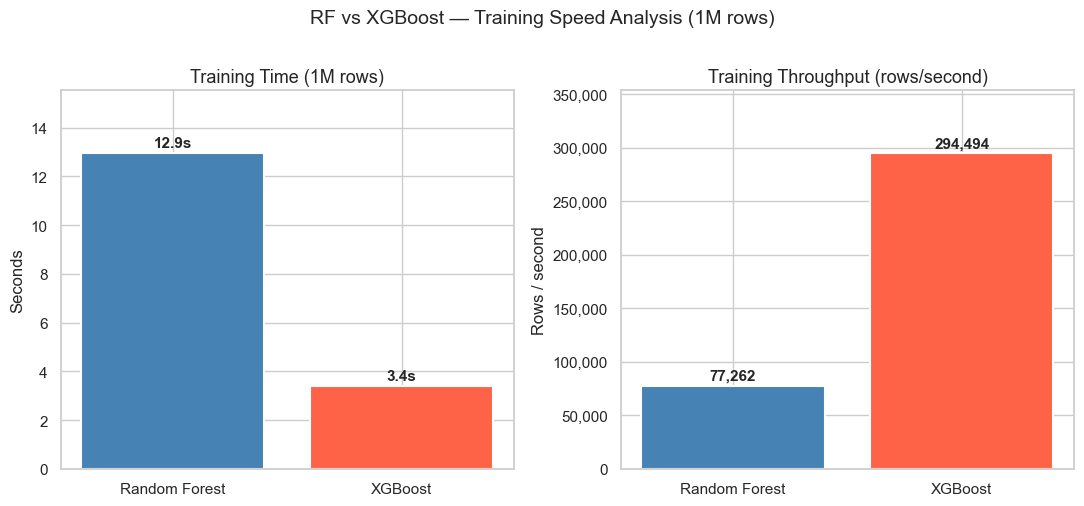

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

models = list(timing_results.keys())
times  = [timing_results[m] for m in models]
colors = ['steelblue', 'tomato']

# Training time
axes[0].bar(models, times, color=colors, edgecolor='white', linewidth=1.5)
for i, (m, t) in enumerate(zip(models, times)):
    axes[0].text(i, t + max(times)*0.01, f"{t:.1f}s", ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[0].set_title("Training Time (1M rows)", fontsize=13)
axes[0].set_ylabel("Seconds")
axes[0].set_ylim(0, max(times) * 1.2)

# Throughput (rows/second)
throughput = [SUBSET_SIZE / t for t in times]
axes[1].bar(models, throughput, color=colors, edgecolor='white', linewidth=1.5)
for i, (m, tp) in enumerate(zip(models, throughput)):
    axes[1].text(i, tp + max(throughput)*0.01, f"{tp:,.0f}", ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[1].set_title("Training Throughput (rows/second)", fontsize=13)
axes[1].set_ylabel("Rows / second")
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
axes[1].set_ylim(0, max(throughput) * 1.2)

plt.suptitle("RF vs XGBoost — Training Speed Analysis (1M rows)", fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig("speed_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

# 6. Final Evaluation on Held-Out Test Set

In [20]:
def evaluate_on_test(name, pipeline, X_test, y_test, threshold=0.5):
    """Compute and log evaluation metrics for a fitted pipeline."""
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred  = (y_proba >= threshold).astype(int)

    metrics = {
        "pr_auc":    average_precision_score(y_test, y_proba),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall":    recall_score(y_test, y_pred),
        "f1":        f1_score(y_test, y_pred),
    }

    prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba)

    return metrics, y_proba, prec_curve, rec_curve


eval_results = {}

for name, pipeline in [("Random Forest", best_rf), ("XGBoost", best_xgb)]:
    with mlflow.start_run(run_name=f"{name.lower().replace(' ', '_')}_final_eval"):
        mlflow.set_tag("model_type", name)
        mlflow.set_tag("stage", "final_evaluation")
        mlflow.set_tag("eval_set", "held_out_test")

        metrics, y_proba, prec_curve, rec_curve = evaluate_on_test(
            name, pipeline, X_test, y_test
        )
        train_time = timing_results[name]

        for k, v in metrics.items():
            mlflow.log_metric(k, v)
        mlflow.log_metric("train_time_s", train_time)

        eval_results[name] = {
            **metrics,
            "train_time": train_time,
            "y_proba": y_proba,
            "prec_curve": prec_curve,
            "rec_curve": rec_curve,
        }

        print(f"\n{'─'*45}")
        print(f" {name} — Test Set Results")
        print(f"{'─'*45}")
        print(f"  PR-AUC    : {metrics['pr_auc']:.4f}")
        print(f"  Precision : {metrics['precision']:.4f}")
        print(f"  Recall    : {metrics['recall']:.4f}")
        print(f"  F1        : {metrics['f1']:.4f}")
        print(f"  Train time: {train_time:.1f}s")


─────────────────────────────────────────────
 Random Forest — Test Set Results
─────────────────────────────────────────────
  PR-AUC    : 0.9972
  Precision : 0.9996
  Recall    : 0.9963
  F1        : 0.9980
  Train time: 12.9s

─────────────────────────────────────────────
 XGBoost — Test Set Results
─────────────────────────────────────────────
  PR-AUC    : 0.9969
  Precision : 0.9903
  Recall    : 0.9963
  F1        : 0.9933
  Train time: 3.4s


## 6.2 Precision-Recall Curves

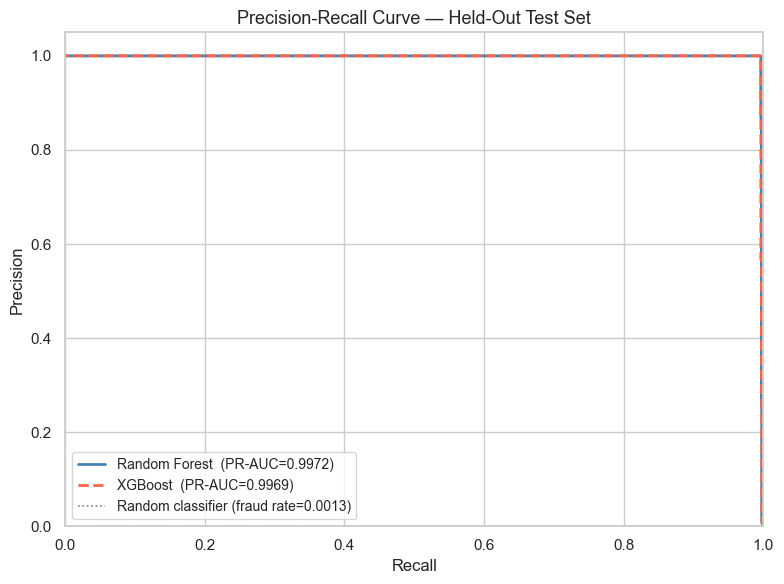

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_config = [
    ("Random Forest", "steelblue",  "-"),
    ("XGBoost",       "tomato",     "--"),
]

for name, color, ls in plot_config:
    r = eval_results[name]
    ax.plot(
        r['rec_curve'], r['prec_curve'],
        color=color, linestyle=ls, linewidth=2,
        label=f"{name}  (PR-AUC={r['pr_auc']:.4f})"
    )

# Baseline (random classifier)
fraud_rate = y_test.mean()
ax.axhline(fraud_rate, color='grey', linestyle=':', linewidth=1.2,
           label=f'Random classifier (fraud rate={fraud_rate:.4f})')

ax.set_xlabel("Recall",    fontsize=12)
ax.set_ylabel("Precision", fontsize=12)
ax.set_title("Precision-Recall Curve — Held-Out Test Set", fontsize=13)
ax.legend(fontsize=10)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.savefig("pr_curve_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

## 6.3 Confusion Matrices

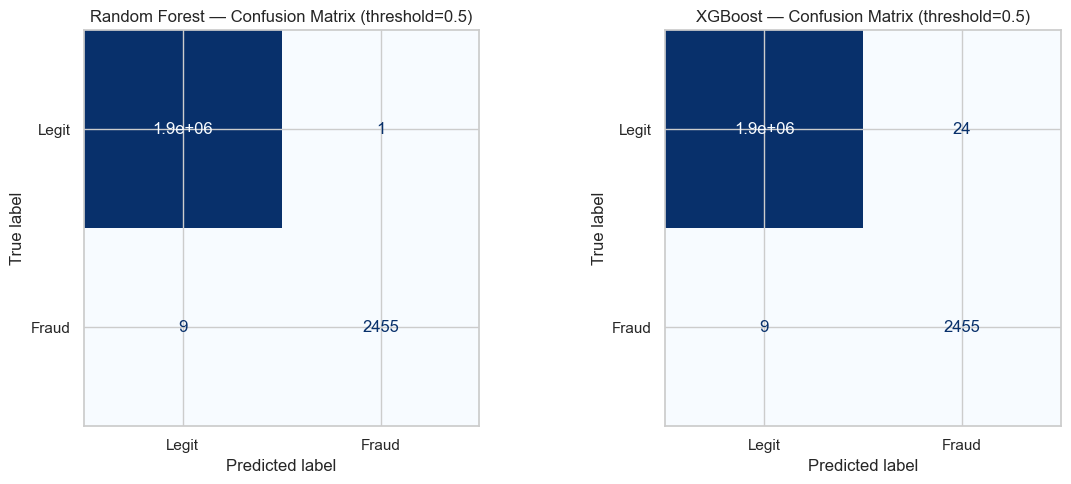

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (name, pipeline) in zip(axes, [("Random Forest", best_rf), ("XGBoost", best_xgb)]):
    y_pred = (eval_results[name]['y_proba'] >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit', 'Fraud'])
    disp.plot(ax=ax, colorbar=False, cmap='Blues')
    ax.set_title(f"{name} — Confusion Matrix (threshold=0.5)", fontsize=12)

plt.tight_layout()
plt.savefig("confusion_matrices.png", dpi=150, bbox_inches='tight')
plt.show()

## 6.4 Performance vs Speed Trade-off

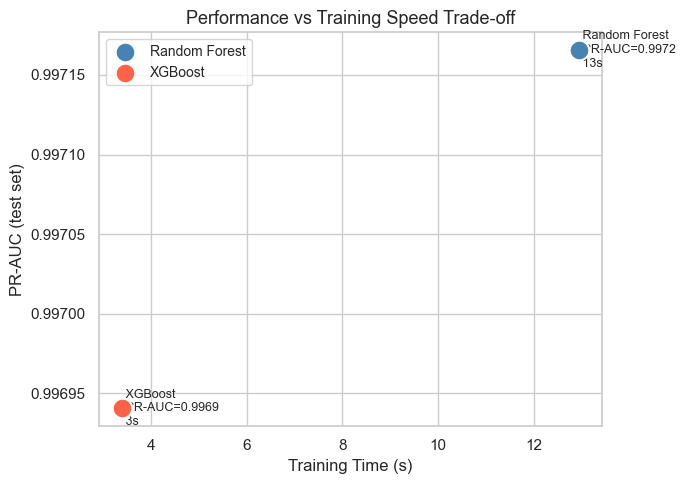

In [24]:
fig, ax = plt.subplots(figsize=(7, 5))

for name, color in [("Random Forest", "steelblue"), ("XGBoost", "tomato")]:
    r = eval_results[name]
    ax.scatter(
        r['train_time'], r['pr_auc'],
        s=200, color=color, zorder=5,
        edgecolors='white', linewidths=1.5,
        label=name
    )
    ax.annotate(
        f" {name}\n PR-AUC={r['pr_auc']:.4f}\n {r['train_time']:.0f}s",
        xy=(r['train_time'], r['pr_auc']),
        fontsize=9, va='center'
    )

ax.set_xlabel("Training Time (s)", fontsize=12)
ax.set_ylabel("PR-AUC (test set)", fontsize=12)
ax.set_title("Performance vs Training Speed Trade-off", fontsize=13)
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig("perf_vs_speed.png", dpi=150, bbox_inches='tight')
plt.show()

# 7. Modeling Summary

## 7.1 Experiment Results

For this project, every model trained reached an PR-AUC close to 99.99% on the held-out (test) set. However looking at the raw value in the confusion matrix, Random Forest shows the least number of False Positives. Nonetheless, XGBoost might be a better option due to its training and inference speed.

| Model | PR-AUC | Precision | Recall | F1 | Train Time (s) | Eval Split |
|---|---|---|---|---|---|---|
| RF (tuned, best params) | 0.9972 | 0.9996 | 0.9963 | 0.9980 | 12.9s| test |
| XGBoost (tuned, best params) | 0.9969 | 0.9903| 0.9963| 0.9933 | 3.4s | test |
